In [31]:
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler # good for financial data
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import streamlit as st

In [32]:
def fetch_data(symbol):
    stock = yf.Ticker(symbol)
    data = stock.history(period="5y")
    return data

data = fetch_data("AAPL")
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-12-21 00:00:00-05:00,121.700987,124.903645,120.172667,124.825768,121251600,0.0,0.0
2020-12-22 00:00:00-05:00,128.116085,130.841755,126.208112,128.378922,168904800,0.0,0.0
2020-12-23 00:00:00-05:00,128.651447,128.914268,127.308078,127.483307,88223700,0.0,0.0
2020-12-24 00:00:00-05:00,127.833739,129.916925,127.619578,128.466476,54930100,0.0,0.0
2020-12-28 00:00:00-05:00,130.432840,133.693895,129.965572,133.061157,124486200,0.0,0.0


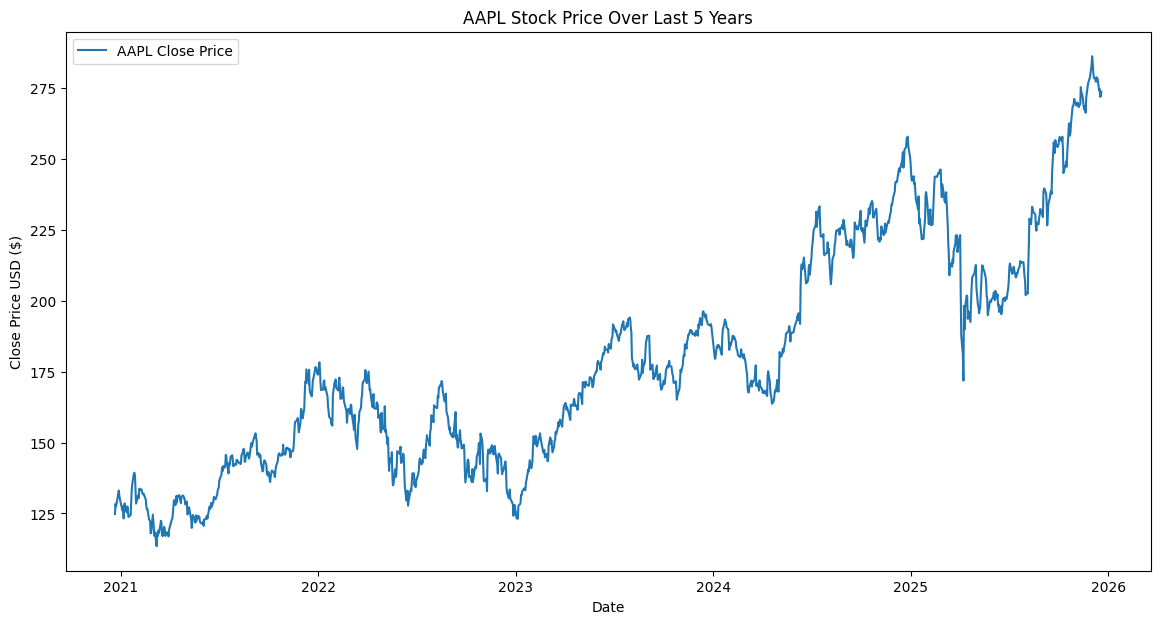

In [33]:
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='AAPL Close Price')
plt.title('AAPL Stock Price Over Last 5 Years')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.legend()
plt.show()

In [34]:
def preprocess_data(df):
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['EMA_50'] = df['Close'].ewm(span=20, adjust=False).mean()
    df['Daily_Return'] = df['Close'].pct_change()
    df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))

    delta = df['Close'].diff(1)
    gain = (delta.where(delta >0,0)).rolling(window=14).mean()
    loss = (-delta.where(delta<0,0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI_14'] = 100 -(100 / (1 + rs))
    df['Middle_Band'] = df['Close'].rolling(window=20).mean()
    df['Upper_Band'] = df['Middle_Band'] + (df['Close'].rolling(window=20).std() * 2)
    df['Lower_Band'] = df['Middle_Band'] - (df['Close'].rolling(window=20).std() * 2)
    df['Momentum'] = df['Close'] - df['Close'].shift(4)
    df['Volatility'] = df['Close'].rolling(window=21).std()

    df.dropna(inplace=True)
    return df

data = preprocess_data(data)
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA_50,EMA_50,Daily_Return,Log_Return,RSI_14,Middle_Band,Upper_Band,Lower_Band,Momentum,Volatility
Date,,,,,,,,,,,,,,,,,
2021-03-04 00:00:00-05:00,118.694922,120.498498,115.643466,117.115570,178155000,0.0,0.0,128.234364,124.428405,-0.015812,-0.015938,24.489606,126.295540,137.906438,114.684642,-1.101646,5.728361
2021-03-05 00:00:00-05:00,117.944245,118.880155,114.619809,118.373199,153766600,0.0,0.0,128.105312,123.851719,0.010738,0.010681,27.093570,125.527070,137.097044,113.957097,-6.210159,5.916656
2021-03-08 00:00:00-05:00,117.895510,117.963754,113.293948,113.440186,154376600,0.0,0.0,127.806538,122.860145,-0.041673,-0.042567,24.752454,124.532666,136.683584,112.381749,-8.540161,6.224915
2021-03-09 00:00:00-05:00,116.043170,118.997136,115.809194,118.051476,129525800,0.0,0.0,127.617901,122.402176,0.040650,0.039845,36.348316,123.761515,135.472677,112.050353,-0.945671,6.088178
2021-03-10 00:00:00-05:00,118.636420,119.104371,116.452623,116.969330,111943300,0.0,0.0,127.387958,121.884762,-0.009167,-0.009209,36.368696,122.980125,134.287535,111.672716,-0.146240,5.896633


In [35]:
def normalize_data(df):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[['Close']])
    return scaled_data, scaler

print(data['Close'][:5])  # Display first 5 rows of preprocessed data
scaled_data, scaler = normalize_data(data)
scaled_data[:5]  # Display first 5 rows of scaled data

Date
2021-03-04 00:00:00-05:00    117.115570
2021-03-05 00:00:00-05:00    118.373199
2021-03-08 00:00:00-05:00    113.440186
2021-03-09 00:00:00-05:00    118.051476
2021-03-10 00:00:00-05:00    116.969330
Name: Close, dtype: float64


array([[0.02127577],
       [0.02855583],
       [0.        ],
       [0.02669346],
       [0.02042922]])

In [36]:
def prepare_data(scaled_data, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(scaled_data)):
        X.append(scaled_data[i - time_steps:i])
        y.append(scaled_data[i,0])
    return np.array(X), np.array(y)

X, y = prepare_data(scaled_data)
X.shape, y.shape

((1147, 60, 1), (1147,))

In [37]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

In [38]:
def build_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        LSTM(50, return_sequences=False),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss = 'mean_squared_error')
    return model

model = build_model((X.shape[1], X.shape[2]))
model.summary()

/Users/tomcuel/.venvs/global_env/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
model.fit(x_train, y_train, batch_size=32, epochs=30)
loss = model.evaluate(x_test, y_test, verbose=0)
print(f'Test Loss: {loss}')

Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0163
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0019
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0014
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0013
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0012
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0012
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0012
Epoch 8/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0011
Epoch 9/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0010
Epoch 10/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0010
Epoch 11/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0010
Epoch 12/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 9.8238e-04
Epoch 13/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 8.8040e-04
Epoch 14/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 8.9153e-04
Epoch 15/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss:

In [40]:
# In-sample predictions (on training + test set)
y_train_pred = model.predict(x_train, verbose=0)
y_train_pred = scaler.inverse_transform(y_train_pred)[:,0]
y_test_pred = model.predict(x_test, verbose=0)
y_test_pred = scaler.inverse_transform(y_test_pred)[:,0]


# Align predictions with dates
prediction_dates = data.index[60:]  # first 60 points are used as input
in_sample_df_train = pd.DataFrame({
    'Date': prediction_dates[:len(y_train_pred)],
    'Predicted': y_train_pred,
    'Actual': data['Close'][60:60+len(y_train_pred)]
})
in_sample_df_test = pd.DataFrame({
    'Date': prediction_dates[len(y_train_pred):],
    'Predicted': y_test_pred,
    'Actual': data['Close'][60+len(y_train_pred):]
})

In [41]:
# Future predictions (10 days)
future_seq = y_test[-60:].reshape(60, 1)
future_preds = []

for day in range(10):
    X_input = future_seq.reshape(1, 60, 1)
    pred = model.predict(X_input, verbose=0)[0][0]
    future_preds.append(pred)
    future_seq = np.vstack([future_seq[1:], [[pred]]])

future_preds = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))[:,0]
future_dates = pd.date_range(start=pd.Timestamp.now() + pd.DateOffset(1), periods=10)

In [42]:
# Plot everything together
fig = go.Figure()
fig.update_layout(width=1400, height=600)

# Historical Close Price
fig.add_trace(go.Scatter(
    x=data.index,
    y=data['Close'],
    mode='lines',
    name='Historical Close',
    line=dict(color='lightgray')
))
# In-sample Predictions for the Training Set
fig.add_trace(go.Scatter(
    x=in_sample_df_train['Date'],
    y=in_sample_df_train['Predicted'],
    mode='lines',
    name='Model Predictions (Train)',
    line=dict(color='blue')
))
# In-sample Predictions for the Test Set
fig.add_trace(go.Scatter(
    x=in_sample_df_test['Date'],
    y=in_sample_df_test['Predicted'],
    mode='lines',
    name='Model Predictions (Test)',
    line=dict(color='orange')
))
# Future Forecasts
fig.add_trace(go.Scatter(
    x=future_dates,
    y=future_preds,
    mode='lines+markers',
    name='Future Forecast',
    line=dict(color='red', dash='dot')
))
fig.update_layout(
    title='Stock Price Prediction: Historical + In-sample + Future Forecast',
    xaxis_title='Date',
    yaxis_title='Price (USD)',
    template='plotly_dark'
)

In [43]:
# Plot everything together
fig = go.Figure()
fig.update_layout(width=1400, height=600)

# Historical Close Price
fig.add_trace(go.Scatter(
    x=data.index[-500:],
    y=data['Close'][-500:],
    mode='lines',
    name='Historical Close',
    line=dict(color='lightgray')
))
# In-sample Predictions (test there since the number of points is smaller)
fig.add_trace(go.Scatter(
    x=in_sample_df_test['Date'][-500:],
    y=in_sample_df_test['Predicted'][-500:],
    mode='lines',
    name='Model Predictions',
    line=dict(color='blue')
))
# Future Forecasts
fig.add_trace(go.Scatter(
    x=future_dates,
    y=future_preds,
    mode='lines+markers',
    name='Future Forecast',
    line=dict(color='red', dash='dot')
))
fig.update_layout(
    title='Stock Price Prediction: Historical + In-sample + Future Forecast',
    xaxis_title='Date',
    yaxis_title='Price (USD)',
    template='plotly_dark'
)